In [1]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.colors import LogNorm
import plotly.graph_objects as go


### 1- Stackoverflow examples

100 198


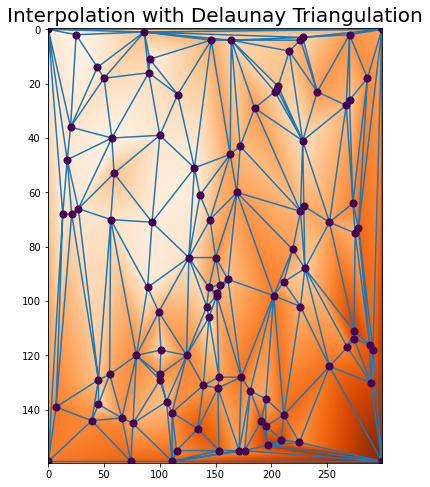

In [2]:
nx, ny = 160, 300

xv, yv = np.meshgrid(np.arange(nx), np.arange(ny))
xv = xv.flatten()
yv = yv.flatten()
pp = np.vstack((xv, yv)).T
    
n = 100

ix = np.random.choice(nx, n).tolist() + [0, 0, nx-1, nx-1]
iy = np.random.choice(ny, n).tolist() + [0, ny-1, 0, ny-1]
f = np.zeros((nx, ny))
for x, y in zip(ix, iy):
    f[x, y] = (x/160)**2 + (y/300)**2 + np.random.rand()
points = np.array(list(zip(ix, iy)))
tri = Delaunay(points)
ss = tri.find_simplex(pp)
ndim = tri.transform.shape[2]
print(n,len(np.unique(ss)))

out = np.zeros((nx, ny))
for i in np.unique(ss): # for all simplices (triangles)
    p = pp[ss == i] # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(np.transpose(p) - tri.transform[i, ndim].reshape(-1,1))
    αβγ = np.c_[np.transpose(b), 1 - b.sum(axis=0)] 
    sp = points[tri.simplices[i]]
    if len(αβγ) > 0:
        out[p[:,0], p[:,1]] = αβγ@f[sp[:,0], sp[:,1]]     
out = out / out.max()

plt.figure(figsize=(6,8))
plt.imshow(out, aspect='auto', cmap='Oranges'), plt.axis(), plt.title('interpolated output with\n barycentric coordinates', size=20)
plt.triplot(points[:,1], points[:,0], tri.simplices)
for p in points:
    plt.scatter(p[1], p[0], c=f[p[0],p[1]], s=50)
plt.title(f'Interpolation with Delaunay Triangulation', size=20)
plt.show()

In [4]:
info = np.loadtxt('E_field/info.txt')
convert_dist=info[1] 
convert_E=info[2]
convert_vel=info[3]

# Load the csv file
df = pd.read_csv('E_field/Fields.csv')

# Convert the DataFrame to a numpy array
Field = df.values
r=Field[:,0]*convert_dist
z=Field[:,1]*convert_dist
Er=Field[:,2]*convert_E
Ez=Field[:,3]*convert_E

E = np.sqrt(Er**2 + Ez**2)


# initial conditions - not needed for interpolation
R = np.loadtxt('E_field/r.txt')*convert_dist
Z = np.loadtxt('E_field/z.txt')*convert_dist


The folowing is a code generated by ChatGPT that tries to adapt the previous code section and apply it to electrospray plumes.
It tries to produce a weighted Delaunay interpolation:

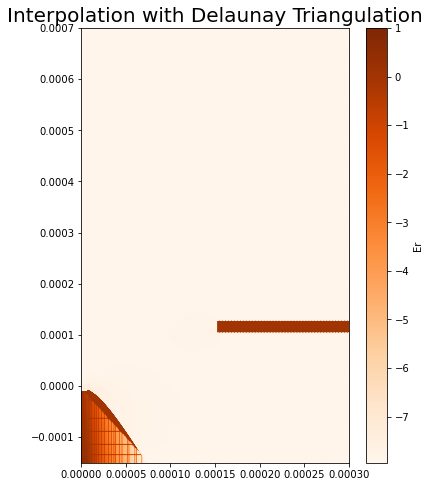

In [5]:


# Sort the data by (r, z) and get unique points with their corresponding Er values
data = sorted(zip(r, z, Er))
points, Er_values = np.array([(x[0], x[1]) for x in data]), np.array([x[2] for x in data])

# Create a grid for interpolation
r_min, r_max, nr = r.min(), r.max(), 500  # Adjust grid size as needed
z_min, z_max, nz = z.min(), z.max(), 500  # Adjust grid size as needed
r_lin = np.linspace(r_min, r_max, nr)
z_lin = np.linspace(z_min, z_max, nz)
rv, zv = np.meshgrid(r_lin, z_lin)

# Flatten and stack the grid points
pp = np.vstack((rv.flatten(), zv.flatten())).T

# Compute Delaunay triangulation of the data points
tri = Delaunay(points)

# Find the simplices containing each point in the grid
ss = tri.find_simplex(pp)

# For each point in the grid, compute its barycentric coordinates within
# its simplex, and use them to interpolate the function value
out = np.zeros_like(rv)
ndim = tri.transform.shape[2]
for i in np.unique(ss):  # for all simplices (triangles)
    p = pp[ss == i]  # all points in the simplex
    # compute the barycentric coordinates of the points
    b = tri.transform[i, :ndim].dot(np.transpose(p) - tri.transform[i, ndim].reshape(-1,1))
    αβγ = np.c_[np.transpose(b), 1 - b.sum(axis=0)] 
    # Here we need to use the indices of the points in the simplices, not the coordinates
    sp_indices = tri.simplices[i]
    # scale and shift the p coordinates to get indices
    ix = ((p[:, 0] - r_min) / (r_max - r_min) * (nr - 1)).astype(int)
    iy = ((p[:, 1] - z_min) / (z_max - z_min) * (nz - 1)).astype(int)
    if len(αβγ) > 0:
        out[ix, iy] = αβγ @ Er_values[sp_indices]
out = out / out.max()  # normalize for color scale

# Plot the interpolated function
plt.figure(figsize=(6,8))
plt.imshow(out.T, origin='lower', extent=[r_min, r_max, z_min, z_max], aspect='auto', cmap='Oranges')
plt.colorbar(label='Er')
plt.scatter(points[:, 0], points[:, 1], c=Er_values, s=10, cmap='Oranges')
plt.title('Interpolation with Delaunay Triangulation', size=20)
plt.show()


### 2- Delaunay triangulation applied to Efield

In [2]:
info = np.loadtxt('E_field/info.txt')
convert_dist=info[1] 
convert_E=info[2]
convert_vel=info[3]

# Load the csv file
df = pd.read_csv('E_field/Fields.csv')

# Convert the DataFrame to a numpy array
Field = df.values
r=Field[:,0]*convert_dist
z=Field[:,1]*convert_dist
Er=Field[:,2]*convert_E
Ez=Field[:,3]*convert_E

E = np.sqrt(Er**2 + Ez**2)


# initial conditions - not needed for interpolation
R = np.loadtxt('E_field/r.txt')*convert_dist
Z = np.loadtxt('E_field/z.txt')*convert_dist


In [3]:
points = np.column_stack((r, z))
tri = Delaunay(points)

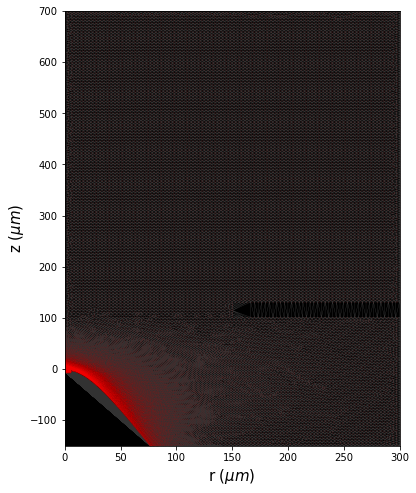

In [4]:
fig = plt.figure(figsize=(6,8), facecolor='white')
ax = fig.add_subplot(111, facecolor='black')
ax.triplot(points[:,0]*1e6, points[:,1]*1e6, tri.simplices, color='white', linewidth=0.4,alpha=0.2)
ax.scatter(points[:,0]*1e6, points[:,1]*1e6, color='r',marker='.', s=0.5, alpha=0.1)
ax.set_xlabel('r ($\mu m$)', size=15, color='black')
ax.set_ylabel('z ($\mu m$)', size=15, color='black')
ax.set_xlim([r.min()*1e6, r.max()*1e6])
ax.set_ylim([z.min()*1e6, z.max()*1e6])
plt.show()

In [5]:
E_array= np.vstack((Er.flatten(), Ez.flatten())).T
interp=LinearNDInterpolator(tri, E_array, fill_value=np.nan, rescale=False)

In [6]:
request=np.array([100e-6,0])
interp(request)

array([[3074143.0021039 , 7574129.58052451]])

### 3- Developing functions

In [7]:
def triangulation (r,z,Er,Ez):
    points = np.column_stack((r, z))
    tri = Delaunay(points)
    E_array= np.vstack((Er.flatten(), Ez.flatten())).T
    interp=LinearNDInterpolator(tri, E_array, fill_value=np.nan, rescale=False)
    return interp


def interp_lin_delaunay(interp,request_pts):    
    return interp(request_pts)

In [8]:
interp=triangulation (r,z,Er,Ez)

In [9]:
request_pts=np.array(([100e-6,0],[150e-6,0]))


In [10]:
val=interp_lin_delaunay(interp,request_pts)
val

array([[3074143.0021039 , 7574129.58052451],
       [1679668.15567389, 7331553.03103123]])

### 4- Validate the interpolation model.

In [11]:
np.shape(Er)

(307083,)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [13]:
# Calculate the mask where sqrt(r^2 + z^2) < 250
mask = np.sqrt(r**2 + z**2) < 250*1e-6

# Apply this mask to your arrays
r_filtered = r[mask]
z_filtered = z[mask]
Er_filtered = Er[mask]
Ez_filtered = Ez[mask]

In [14]:
print(np.size(r))
print(np.size(r_filtered))

307083
289052


In [15]:
# Combine features and targets
features = np.column_stack((r_filtered, z_filtered))
targets = np.column_stack((Er_filtered, Ez_filtered))

# Split data into training and testing datasets
train_features, test_features, train_targets, test_targets = train_test_split(features, targets, test_size=0.2, random_state=42)

print(f'Training features size: {train_features.shape}')
print(f'Testing features size: {test_features.shape}')
print(f'Training targets size: {train_targets.shape}')
print(f'Testing targets size: {test_targets.shape}')


Training features size: (231241, 2)
Testing features size: (57811, 2)
Training targets size: (231241, 2)
Testing targets size: (57811, 2)


In [16]:
interp=triangulation (train_features[:,0],train_features[:,1],train_targets[:,0],train_targets[:,1])

In [17]:
request_pts=np.vstack((test_features[:,0],test_features[:,1])).T

In [18]:
predictions=interp_lin_delaunay(interp,request_pts)

In [19]:
# Check for NaNs or infs in test_targets
print("NaNs in test_targets:", np.isnan(test_targets).any())
print("Infs in test_targets:", np.isinf(test_targets).any())

# Check for NaNs or infs in predictions
print("NaNs in predictions:", np.isnan(predictions).any())
print("Infs in predictions:", np.isinf(predictions).any())


NaNs in test_targets: False
Infs in test_targets: False
NaNs in predictions: True
Infs in predictions: False


In [20]:
# Find indices where predictions[:, 0] contains NaNs
indices_nan_0 = np.where(np.isnan(predictions[:, 0]))

# Find indices where predictions[:, 1] contains NaNs
indices_nan_1 = np.where(np.isnan(predictions[:, 1]))

print("Indices with NaNs in first column of predictions:", indices_nan_0)
print("Indices with NaNs in second column of predictions:", indices_nan_1)


Indices with NaNs in first column of predictions: (array([22069, 23917, 25116, 43214, 52629]),)
Indices with NaNs in second column of predictions: (array([22069, 23917, 25116, 43214, 52629]),)


In [21]:
# Find the unique indices across both columns where there are NaNs
indices_nan = np.unique(np.concatenate((indices_nan_0[0], indices_nan_1[0])))

# Delete rows from predictions
predictions = np.delete(predictions, indices_nan, axis=0)

# Delete corresponding rows from test_targets
test_targets = np.delete(test_targets, indices_nan, axis=0)


In [22]:
# Calculate absolute error
absolute_error = np.abs(predictions - test_targets)

# Calculate relative error. We add a small constant to the denominator to avoid division by zero.
epsilon = 1e-7
relative_error = absolute_error / (np.abs(test_targets) + epsilon)

# Now, `relative_error` is an array of the same shape as `predictions` and `test_targets`,
# with each element being the relative error for the corresponding prediction-target pair.

In [23]:
# Calculate the mean relative error for each column
mean_relative_error_col0 = np.mean(relative_error[:, 0])
mean_relative_error_col1 = np.mean(relative_error[:, 1])
print("Mean Relative Error for first column:", mean_relative_error_col0)
print("Mean Relative Error for second column:", mean_relative_error_col1)


Mean Relative Error for first column: 2828028716967.656
Mean Relative Error for second column: 4203889948826.358


In [24]:
# Calculate the median relative error for each column
median_relative_error_col0 = np.median(relative_error[:, 0])
median_relative_error_col1 = np.median(relative_error[:, 1])
print("Median Relative Error for first column:", median_relative_error_col0)
print("Median Relative Error for second column:", median_relative_error_col1)

Median Relative Error for first column: 2.133551629247276e-08
Median Relative Error for second column: 3.1478284507269547e-09


Text(0.5, 1.0, 'Linear Interpolatoin using Delaunay Triangulation')

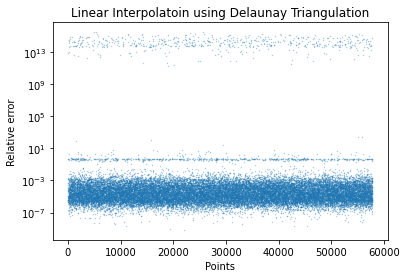

In [36]:
# Create scatter plot
plt.scatter(np.arange(len(relative_error[:, 0])), relative_error[:, 0], marker='.', s=0.5, alpha=0.5)


# Set the x and y axis scales to logarithmic
plt.yscale('log')
plt.xlabel('Points')
plt.ylabel('Relative error')
plt.title('Linear Interpolatoin using Delaunay Triangulation')

# Adding labels for better readability
#plt.xlabel('Relative Error for Column 0')
#plt.ylabel('Relative Error for Column 1')

# Show the plot
#plt.show()

In [35]:
# Count the number of points that have been predicted with more than 1% realtive error
count = np.sum(relative_error[:, 0] > 1)

print("Percentage of points that have a relative error >1%  is ", 100*count/np.shape(relative_error)[0],'%')

Percentage of points that have a relative error >1%  is  1.0777427948655849 %


57806

### 5- Compute the Electric force F=q*(Er+Ez)

In [29]:
def compute_acc_laplace (interp,x,y,z,charge,mass):
    r = np.sqrt(x**2 + y**2) # convert cartesian to cylindrical
    request_pts=np.vstack((r,z)).T
    E_array=interp_lin_delaunay(interp,request_pts) # nx2 array of Er and Ez
    F_cyl=charge*E_array # nx2 array of Fr and Fz
    a_lap_cyl=F_cyl/mass  # nx2 array of ar and az
    #convert cylindrical coordinates to cartesian coordinates
    a_lap_cart=np.zeros_like(a_lap_cyl) # define an array for the acceleration in the cartesian coordinates
    theta =np.arctan2(y, x) # Angle in the cylindrical coordinates formed by the point (x,y)
    a_lap_cart[:,0]=a_lap_cyl[:,0]*np.cos(theta) # a_cart(x) =a_cyl(r)*cos(theta)
    a_lap_cart[:,1]=a_lap_cyl[:,0]*np.sin(theta) # a_cart(x) =a_cyl(r)*cos(theta)
    a_lap_cart[:,2]=a_lap_cyl[:,1] # a_cart(z) =a_cyl(z)
    return a_lap_cart